In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import tensorflow_probability
from tensorflow_probability.python.internal.backend import jax as tf2jax
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels
import optax
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import sys; sys.path.insert(0, '..')
from riemannianvectorgp.sparse_gp import SparseGaussianProcess
from riemannianvectorgp.gp import GaussianProcess
from riemannianvectorgp.kernel import FourierFeatures, ScaledKernel, TFPKernel
from einops import rearrange

# from jax.config import config

# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def plot(x,y,f, samples=False):
    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)
    
    fig = plt.figure()
    # ax = fig.add_subplot(projection='polar')
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.plot(x,m,linewidth=2)
    ax.fill_between(x, l, u, alpha=0.5)
    
    if samples:
        for i in range(f.shape[0]):
            ax.plot(x,f[i,:], color="gray",alpha=0.5)

class GlobalRNG:
    def __init__(self, seed: int = np.random.randint(2147483647)):
        self.key = jax.random.PRNGKey(seed)

    def __iter__(self):
        return self
    
    def __next__(self):
        (ret_key, self.key) = jr.split(self.key)
        return ret_key

def plot(x, y, gp, params, state, samples=False):
    fig = plt.figure()
    # ax = fig.add_subplot(projection="polar")
    ax = fig.add_subplot()
    
    state = gp.randomize(params, state, next(rng))

    K = gp.kernel.matrix(
        params.kernel_params, params.inducing_locations, params.inducing_locations
    )
    K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")

    M, OD = params.inducing_pseudo_log_err_stddev.shape
    Sigma = rearrange(
        jnp.exp(2 * params.inducing_pseudo_log_err_stddev), "M OD -> (M OD)"
    )
    Sigma = jnp.diag(Sigma)
    inducing_pseudo_mean = rearrange(params.inducing_pseudo_mean, "M OD -> (M OD)")

    inducing_mean = tf2jax.linalg.matvec(
        K + Sigma,
        inducing_pseudo_mean,
    )
    inducing_mean = rearrange(inducing_mean, "(M OD) -> M OD", M=M, OD=OD)
    f = gp(params, state, x)[:, :, 0]
    f_prior = gp.prior(params.kernel_params, state.prior_state, x)[:, :, 0]

    k = kernel.matrix(params.kernel_params, x, x)[0, :, 0]

    x = x[:, 0]
    y = y[:, 0]

    ax.scatter(x, y)

    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)

    ax.plot(x, m, linewidth=2)
    ax.fill_between(x, l, u, alpha=0.5)

    if samples:
        for i in range(f.shape[0]):
            ax.plot(x, f[i, :], color="gray", alpha=0.5)

    ax.scatter(params.inducing_locations[:, 0], inducing_mean, zorder=6)
    ax.errorbar(
        params.inducing_locations[:, 0],
        inducing_mean[:, 0],
        yerr=jnp.exp(params.inducing_pseudo_log_err_stddev[:, 0]),
        linestyle="none",
        zorder=5
    )


def plot_gp(x, y, gp, params, state, samples=False):

    fig, axs = plt.subplots(3, 1, figsize=(4, 9))

    state = gp.randomize(params, state, next(rng))

    K = gp.kernel.matrix(
        params.kernel_params, params.inducing_locations, params.inducing_locations
    )
    K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")

    M, OD = params.inducing_pseudo_log_err_stddev.shape
    Sigma = rearrange(
        jnp.exp(2 * params.inducing_pseudo_log_err_stddev), "M OD -> (M OD)"
    )
    Sigma = jnp.diag(Sigma)
    inducing_pseudo_mean = rearrange(params.inducing_pseudo_mean, "M OD -> (M OD)")

    inducing_mean = tf2jax.linalg.matvec(
        K + Sigma,
        inducing_pseudo_mean,
    )
    inducing_mean = rearrange(inducing_mean, "(M OD) -> M OD", M=M, OD=OD)
    f = gp(params, state, x)[:, :, 0]
    f_prior = gp.prior(params.kernel_params, state.prior_state, x)[:, :, 0]

    k = kernel.matrix(params.kernel_params, x, x)[0, :, 0]

    x = x[:, 0]
    y = y[:, 0]

    axs[0].scatter(x, y)
    # ax.set_rmin-(-4)

    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)

    axs[0].plot(x, m, linewidth=2)
    axs[0].fill_between(x, l, u, alpha=0.5)

    if samples:
        for i in range(f.shape[0]):
            axs[0].plot(x, f[i, :], color="gray", alpha=0.5)

    axs[0].scatter(params.inducing_locations[:, 0], inducing_mean, zorder=6)
    axs[0].errorbar(
        params.inducing_locations[:, 0],
        inducing_mean[:, 0],
        yerr=jnp.exp(params.inducing_pseudo_log_err_stddev[:, 0]),
        linestyle="none",
        zorder=5
    )
    axs[0].set_title("Sparse GP")
    axs[1].plot(x, f_prior.T)
    axs[1].set_title("Prior samples")
    axs[2].plot(x, k)
    axs[2].set_title("Kernel")

    plt.tight_layout()


In [45]:
rng = GlobalRNG()

In [46]:
x = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x) + jr.normal(next(rng), x.shape)/10

In [47]:
kernel = ScaledKernel(TFPKernel(tfk.ExponentiatedQuadratic, 1, 1))
kernel_params = kernel.init_params(next(rng))
kernel_params

ScaledKernelParams(log_amplitude=DeviceArray([0.], dtype=float32), sub_kernel_params=TFPKernelParameters(log_length_scales=DeviceArray(0., dtype=float32)))

(101, 101, 1, 1)
(101, 101, 1, 1)


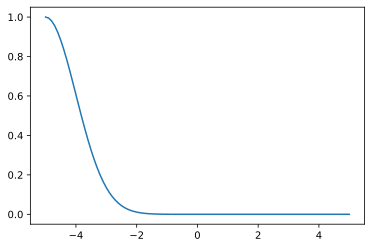

In [48]:
k = kernel.matrix(kernel_params, x, x)
print(k.shape)
plt.plot(x[:, 0], k[0, :, 0, 0])
print(k.shape)

In [49]:
gp = SparseGaussianProcess(kernel, 1, 1, 11, 67, 17)
(params, state) = gp.init_params_with_state(next(rng))

In [50]:
state._fields

('inducing_weights', 'cholesky', 'prior_state')

In [51]:
for i, name in enumerate(state._fields):
    print(name, state[i].shape)

inducing_weights (17, 11, 1)
cholesky (11, 11, 1, 1)


AttributeError: 'FourierFeatureState' object has no attribute 'shape'

In [52]:
for i, name in enumerate(params._fields):
    print(name, params[i].shape)

log_error_stddev (1,)
inducing_locations (11, 1)
inducing_pseudo_mean (11, 1)
inducing_pseudo_log_err_stddev (11, 1)


AttributeError: 'ScaledKernelParams' object has no attribute 'shape'

In [53]:
params = params._replace(inducing_locations = jnp.expand_dims(jnp.linspace(-5,5,11), -1))

In [54]:
state = gp.resample_prior_basis(params,state,next(rng))
state = gp.randomize(params,state,next(rng))

In [55]:
from riemannianvectorgp.sparse_gp import SparseGaussianProcessState

key = next(rng)

(S, OD, ID, M, L) = (
    gp.num_samples,
    gp.output_dimension,
    gp.input_dimension,
    gp.num_inducing,
    gp.num_basis,
)
inducing_locations = params.inducing_locations
inducing_pseudo_mean = params.inducing_pseudo_mean
inducing_pseudo_log_err_stddev = params.inducing_pseudo_log_err_stddev
kernel_params = params.kernel_params
prior_state = state.prior_state

print(f"{inducing_locations.shape=}")
print(f"{inducing_pseudo_mean.shape=}")
print(f"{inducing_pseudo_log_err_stddev.shape=}")

inducing_pseudo_mean = rearrange(inducing_pseudo_mean, "M OD -> (M OD)")
inducing_pseudo_log_err_stddev = rearrange(inducing_pseudo_log_err_stddev, "M OD -> (M OD)")

print(f"{inducing_locations.shape=}")
print(f"{inducing_pseudo_mean.shape=}")
print(f"{inducing_pseudo_log_err_stddev.shape=}")

(k1, k2) = jr.split(key)
prior_state = gp.prior.resample_weights(
    kernel_params, prior_state, gp.num_samples, k1
)
state = SparseGaussianProcessState(
    state.inducing_weights, state.cholesky, prior_state
)

K = gp.kernel.matrix(
    kernel_params, inducing_locations, inducing_locations
)

print(f"{K.shape=}")

K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")

print(f"{K.shape=}")

inducing_noise_kernel = jnp.diag(jnp.exp(inducing_pseudo_log_err_stddev * 2))

print(f"{inducing_noise_kernel.shape=}")

K = K + inducing_noise_kernel

(cholesky, _) = jsp.linalg.cho_factor(
    K,
    lower=True,
)

print(f"{cholesky.shape=}")

prior = gp.prior(
    params.kernel_params, state.prior_state, inducing_locations
)

print(f"{prior.shape=}")

prior = rearrange(prior, "S M OD -> S (M OD)")

print(f"{prior.shape=}")

noise_cholesky = jnp.diag(jnp.exp(inducing_pseudo_log_err_stddev))
print(f"{noise_cholesky.shape=}")

sample_noise = jnp.einsum("ij,sj->si", noise_cholesky, jr.normal(k2, (S, M * OD)))

print(f"{sample_noise.shape=}")

residual = prior + sample_noise

print(f"{residual.shape=}")

data_part = tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solvevec(
                tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solvevec(
                    residual
                ),
                adjoint=True,
            )
print(f"{data_part.shape=}")

inducing_weights = (
            inducing_pseudo_mean
            - tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solvevec(
                tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solvevec(
                    residual
                ),
                adjoint=True,
            )
        )

inducing_weights = rearrange(inducing_weights, "S (M OD) -> S M OD", M=M, OD=OD)

print(f"{inducing_weights.shape=}")



inducing_locations.shape=(11, 1)
inducing_pseudo_mean.shape=(11, 1)
inducing_pseudo_log_err_stddev.shape=(11, 1)
inducing_locations.shape=(11, 1)
inducing_pseudo_mean.shape=(11,)
inducing_pseudo_log_err_stddev.shape=(11,)
K.shape=(11, 11, 1, 1)
K.shape=(11, 11)
inducing_noise_kernel.shape=(11, 11)
cholesky.shape=(11, 11)
prior.shape=(17, 11, 1)
prior.shape=(17, 11)
noise_cholesky.shape=(11, 11)
sample_noise.shape=(17, 11)
residual.shape=(17, 11)
data_part.shape=(17, 11)
inducing_weights.shape=(17, 11, 1)


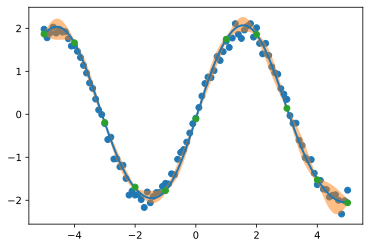

In [56]:
x_ind = jnp.linspace(-5,5, 11)[:, np.newaxis]
y_ind = 2 * jnp.sin(x_ind) + jr.normal(next(rng), x_ind.shape)/10
params = gp.set_inducing_points(
    params,
    x_ind,
    y_ind,
    jnp.ones_like(y_ind) * 0.04
)
state = gp.randomize(params,state,next(rng))
plot(x,y,gp, params, state, samples=False)

In [57]:
inducing_err_stddev = jnp.ones_like(y_ind) * 0.0001
inducing_means = y_ind
inducing_locations = x_ind

M, OD = inducing_means.shape

print(f"{inducing_means.shape=}")
print(f"{inducing_err_stddev.shape=}")
print(f"{inducing_locations.shape=}")

inducing_means = rearrange(inducing_means, "M OD -> (M OD)")
inducing_err_stddev = rearrange(inducing_err_stddev, "M OD -> (M OD)")

print(f"{inducing_means.shape=}")
print(f"{inducing_err_stddev.shape=}")

K = gp.kernel.matrix(
            params.kernel_params, inducing_locations, inducing_locations
        )

print(f"{K.shape=}")

K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")

print(f"{K.shape=}")

inducing_noise_kernel = jnp.diag(jnp.power(inducing_err_stddev, 2))

K = K + inducing_noise_kernel

print(f"{K.shape=}")

inducing_pseudo_mean = tf2jax.linalg.matvec(
    tf2jax.linalg.inv(K), inducing_means
)

(cholesky, _) = jsp.linalg.cho_factor(
    K,
    lower=True,
)
inducing_pseudo_mean_2 = tf2jax.linalg.LinearOperatorLowerTriangular(
    cholesky
).solvevec(
    tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solvevec(
        inducing_means
    ),
    adjoint=True,
)

print(f"{inducing_pseudo_mean.shape=}")
print(f"{inducing_pseudo_mean_2.shape=}")

inducing_pseudo_mean = rearrange(
    inducing_pseudo_mean, "(M OD) -> M OD", M=M, OD=OD
)
inducing_err_stddev = rearrange(
    inducing_err_stddev, "(M OD) -> M OD", M=M, OD=OD
)

print(f"{inducing_pseudo_mean.shape=}")
print(f"{jnp.log(inducing_err_stddev).shape=}")
print(f"{inducing_locations.shape=}")



inducing_means.shape=(11, 1)
inducing_err_stddev.shape=(11, 1)
inducing_locations.shape=(11, 1)
inducing_means.shape=(11,)
inducing_err_stddev.shape=(11,)
K.shape=(11, 11, 1, 1)
K.shape=(11, 11)
K.shape=(11, 11)
inducing_pseudo_mean.shape=(11,)
inducing_pseudo_mean_2.shape=(11,)
inducing_pseudo_mean.shape=(11, 1)
jnp.log(inducing_err_stddev).shape=(11, 1)
inducing_locations.shape=(11, 1)


In [58]:
(S, OD, ID, M) = (
    gp.num_samples,
    gp.output_dimension,
    gp.input_dimension,
    gp.num_inducing,
)
N, _ = x.shape

inducing_locations = params.inducing_locations
kernel_params = params.kernel_params
inducing_weights = state.inducing_weights
prior_state = state.prior_state

print(f"{inducing_locations.shape=}")
print(f"{inducing_weights.shape=}")

f_prior = gp.prior(kernel_params, prior_state, x)

print(f"{f_prior.shape=}")

K = gp.kernel.matrix(kernel_params, x, inducing_locations)

print(f"{K.shape=}")

f_data_einsum = jnp.einsum("mnop,snp->smo", K, inducing_weights)

K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")
inducing_weights = rearrange(inducing_weights, "S M OD -> S (M OD)")

print(f"{K.shape=}")

f_data = jnp.einsum("ij,sj->si", K, inducing_weights)

f_data = rearrange(f_data, "S (N OD) -> S N OD", N=N, OD=OD)

print(f"{f_data.shape=}")
print(f"{f_data_einsum.shape=}")

f = f_prior + f_data

print(f"{f.shape=}")




inducing_locations.shape=(11, 1)
inducing_weights.shape=(17, 11, 1)
f_prior.shape=(17, 101, 1)
K.shape=(101, 11, 1, 1)
K.shape=(101, 11)
f_data.shape=(17, 101, 1)
f_data_einsum.shape=(17, 101, 1)
f.shape=(17, 101, 1)


In [59]:
gp.prior_kl(params, state)

DeviceArray(41.964867, dtype=float32)

In [60]:
(OD, ID, M) = (gp.output_dimension, gp.input_dimension, gp.num_inducing)
inducing_locations = params.inducing_locations
inducing_pseudo_mean = params.inducing_pseudo_mean
inducing_pseudo_log_err_stddev = params.inducing_pseudo_log_err_stddev
kernel_params = params.kernel_params
cholesky = state.cholesky

print(f"{inducing_locations.shape=}")
print(f"{inducing_pseudo_mean.shape=}")
print(f"{inducing_pseudo_log_err_stddev.shape=}")
print(f"{cholesky.shape=}")

cholesky = rearrange(cholesky, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")
inducing_pseudo_mean = rearrange(inducing_pseudo_mean, "M OD -> (M OD)")
inducing_pseudo_log_err_stddev = rearrange(
    inducing_pseudo_log_err_stddev, "M OD -> (M OD)"
)
print(f"{inducing_pseudo_mean.shape=}")
print(f"{inducing_pseudo_log_err_stddev.shape=}")
print(f"{cholesky.shape=}")

print(f"{cholesky.shape=}")
print(f"{inducing_pseudo_log_err_stddev.shape=}")


logdet_term = 2 * jnp.sum(jnp.log(jnp.diag(cholesky))) - 2 * jnp.sum(
    inducing_pseudo_log_err_stddev
)

K = gp.kernel.matrix(
    kernel_params, inducing_locations, inducing_locations
)
K = rearrange(K, "M1 M2 OD1 OD2 -> (M1 OD1) (M2 OD2)")
cholesky_inv = tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solve(
            tf2jax.linalg.LinearOperatorLowerTriangular(cholesky).solve(jnp.eye(M)),
            adjoint=True,
        )

print(f"{K.shape=}")
print(f"{cholesky_inv.shape=}")

trace_term = jnp.sum(cholesky_inv * K)
reparameterized_quadratic_form_term = jnp.einsum(
            "i,ij,j", inducing_pseudo_mean, K, inducing_pseudo_mean
        )



print(f"{logdet_term.shape=}")
print(f"{trace_term.shape=}")
print(f"{reparameterized_quadratic_form_term.shape=}")

print(f"{logdet_term=}")
print(f"{trace_term=}")
print(f"{reparameterized_quadratic_form_term=}")

print((
            logdet_term
            - (OD * ID * M)
            + trace_term
            + reparameterized_quadratic_form_term
        ) / 2)





inducing_locations.shape=(11, 1)
inducing_pseudo_mean.shape=(11, 1)
inducing_pseudo_log_err_stddev.shape=(11, 1)
cholesky.shape=(11, 11, 1, 1)
inducing_pseudo_mean.shape=(11,)
inducing_pseudo_log_err_stddev.shape=(11,)
cholesky.shape=(11, 11)
cholesky.shape=(11, 11)
inducing_pseudo_log_err_stddev.shape=(11,)
K.shape=(11, 11)
cholesky_inv.shape=(11, 11)
logdet_term.shape=()
trace_term.shape=()
reparameterized_quadratic_form_term.shape=()
logdet_term=DeviceArray(70.85044, dtype=float32)
trace_term=DeviceArray(6.774369, dtype=float32)
reparameterized_quadratic_form_term=DeviceArray(17.304928, dtype=float32)
41.964867


In [61]:
n_data = x.shape[0]

f = gp(params, state, x)

print(f"{f.shape}")
print(f"{y.shape}")

s = jnp.exp(params.log_error_stddev)

print(f"{s.shape}")

(n_samples, _, n_batch) = f.shape

c = n_data / (n_batch * n_samples * 2)

l = n_data * jnp.sum(jnp.log(s)) + c * jnp.sum(((y - f) / s) ** 2)

print(l)


(17, 101, 1)
(101, 1)
(1,)
180.19543


In [62]:
gp.loss(params,state,next(rng),x,y,x.shape[0])[0]

DeviceArray(228.6051, dtype=float32)

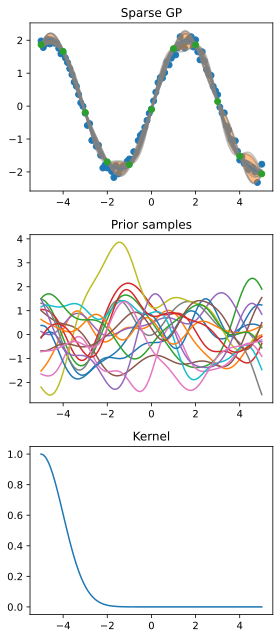

In [63]:
state = gp.randomize(params,state,next(rng))
plot_gp(x,y,gp, params, state, samples=True)

In [64]:
opt = optax.chain(optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8), optax.scale(-0.01))
opt_state = opt.init(params)

In [65]:
for i in range(300):
    ((train_loss,state),grads) = jax.value_and_grad(gp.loss, has_aux=True)(params,state,next(rng),x,y,x.shape[0])
    (updates,opt_state) = opt.update(grads, opt_state)
    params = optax.apply_updates(params,updates)
    if i <= 10 or i % 20 == 0: print(i,"Loss:",train_loss)

0 Loss: 259.0481
1 Loss: 191.46451
2 Loss: 177.08795
3 Loss: 175.55656
4 Loss: 149.19197
5 Loss: 171.37941
6 Loss: 155.4695
7 Loss: 137.76822
8 Loss: 131.35953
9 Loss: 119.60419
10 Loss: 118.125
20 Loss: 103.54294
40 Loss: 101.62579
60 Loss: 101.53845
80 Loss: 100.999176
100 Loss: 101.54083
120 Loss: 103.04176
140 Loss: 103.0275
160 Loss: 101.89223
180 Loss: 101.20404
200 Loss: 102.42351
220 Loss: 100.90398
240 Loss: 103.10071
260 Loss: 101.5453
280 Loss: 102.28528


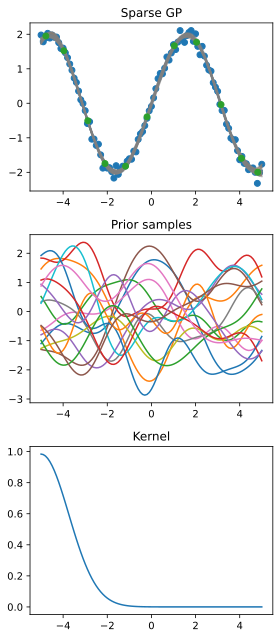

In [67]:
state = gp.randomize(params,state,next(rng))
plot_gp(x, y, gp, params, state, samples=True)

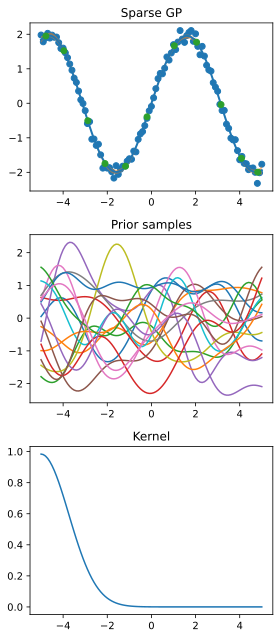

In [68]:
plot_gp(x, y, gp, params, state, samples=False)

In [137]:
x_ind = jnp.expand_dims(jnp.linspace(-5, 5, 11), -1)
yi = 2 * jnp.sin(x_ind).T

params = gp.set_inducing_points(
    params,
    x_ind,
    yi,
    jnp.ones_like(yi) * 1.0
)

In [70]:
gp_dense = GaussianProcess(kernel, 1, 1, 10)
(dense_params, dense_state) = gp_dense.init_params_with_state(next(rng))
dense_params = dense_params._replace(kernel_params=kernel_params)
dense_state = gp_dense.condition(dense_params, x, y, 0.1 * jnp.ones_like(x)[:, 0], next(rng))


In [ ]:
# dense_state = gp_dense.randomize(dense_params, dense_state, next(rng))

m, K = gp_dense(dense_params, dense_state, x)
samples = gp_dense.sample(dense_params, dense_state, x, next(rng), obs_noise=1e-5)

plot(x[:, 0], y[0, :], samples[:, 0, :], samples=True)
k = jnp.sqrt(jnp.diagonal(K[0]))
plt.plot(x[:, 0], m[0, :], color='red')
plt.fill_between(x[:, 0], m[0, :] - (k * 1.96), m[0, :] + (k * 1.96), color='red', alpha=0.7)

In [71]:
K[0].shape

(101, 101)

In [34]:
x = jnp.expand_dims(jnp.linspace(-5,5,101)[0:30:3], -1)
x_dense = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x).T + jr.normal(next(rng), x.T.shape)/10

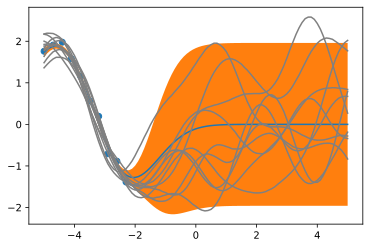

In [47]:
gp_dense = GaussianProcess(kernel, 1, 1, 10)
(dense_params, dense_state) = gp_dense.init_params_with_state(next(rng))
dense_params = dense_params._replace(kernel_params=kernel_params)
dense_state = gp_dense.condition(dense_params, x, y, 0.1 * jnp.ones_like(x)[:, 0], next(rng))

m, K = gp_dense(dense_params, dense_state, x_dense)
samples = gp_dense.sample(dense_params, dense_state, x_dense, next(rng), obs_noise=1e-5)
k = jnp.diagonal(K[0,:,:])

plt.scatter(x[:,0], y[0, :])
plt.plot(x_dense[:,0], m[0,:])
plt.fill_between(x_dense[:,0], m[0,:]-(k* 1.96), m[0,:]+(k* 1.96), zorder=2)
for i in range(samples.shape[0]):
    plt.plot(x_dense[:,0], samples[i, 0 ,:], color='grey', zorder=5)

In [44]:
samples

DeviceArray([[[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             ...,

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]],

             [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)